In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sales_df = pd.read_csv('/content/Advertising.csv')

In [3]:
sales_df

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9
...,...,...,...,...,...
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5


In [4]:
# View first 5 views
sales_df.head(5)

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [5]:
# View last 5 views
sales_df.tail(5)

,Unnamed: 0,TV,Radio,Newspaper,Sales
195,196,38.2,3.7,13.8,7.6
196,197,94.2,4.9,8.1,9.7
197,198,177.0,9.3,6.4,12.8
198,199,283.6,42.0,66.2,25.5
199,200,232.1,8.6,8.7,13.4


# Sale Prices EDA

In [6]:
sales_df.describe()

,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [7]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [8]:
# Dropped the first column
sales_df.drop('Unnamed: 0',axis=1,inplace=True)

In [10]:
sales_df.shape

(200, 4)

In [11]:
sales_df.count()

,0
TV,200
Radio,200
Newspaper,200
Sales,200


In [12]:
# Find null values
sales_df.isna().sum()

,0
TV,0
Radio,0
Newspaper,0
Sales,0


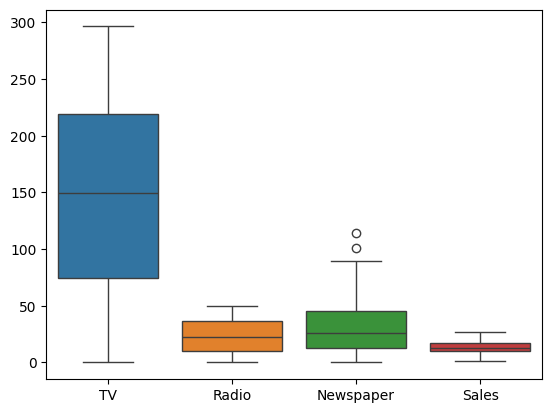

In [13]:
# Detect outliers
import seaborn as sns
sns.boxplot(sales_df)
plt.show()

In [14]:
# Removed outliers
def remove_outliers(df):
  numeric_cols = sales_df[['Newspaper']]
  Q1 = numeric_cols.quantile(0.25)
  Q2 = numeric_cols.median()
  Q3 = numeric_cols.quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  mask = ~((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).any(axis=1)
  return df[mask]

In [15]:
sale_prices_df = remove_outliers(sales_df)

# Correlation Matrix

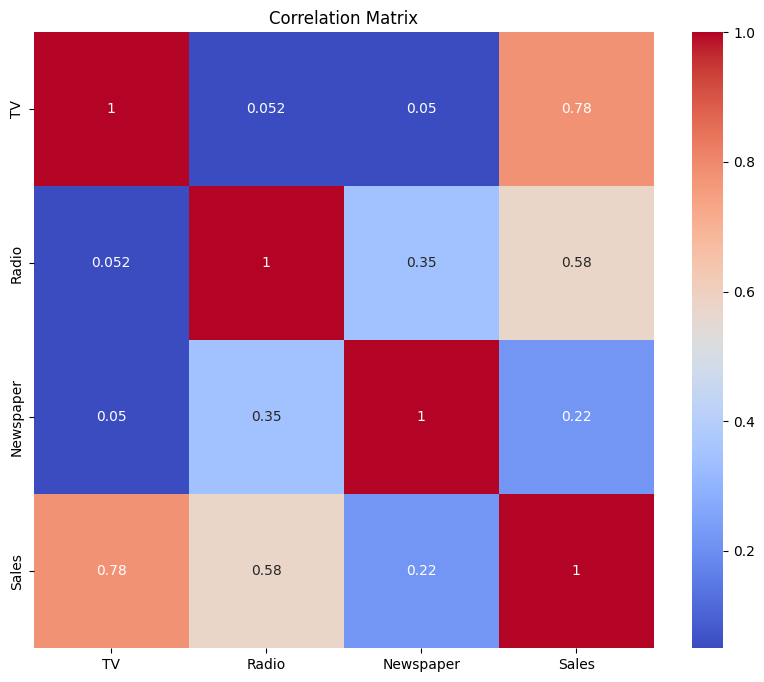

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(sale_prices_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show();

# ML - Baseline Model

In [19]:
X = sale_prices_df.drop(['Sales'],axis=1)
y = sale_prices_df['Sales'].copy()

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((158, 3), (40, 3), (158,), (40,))

In [22]:
num_features = X_train.select_dtypes(include=[np.number]).columns
cat_features = X_train.select_dtypes(exclude=[np.number]).columns

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
num_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='median')),
    ('scale',StandardScaler())
])

cat_pipeline = Pipeline([
    ('impute',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'))
])

transformer = ColumnTransformer([
    ('num',num_pipeline,num_features),
    ('object',cat_pipeline,cat_features)
],remainder='passthrough')

In [25]:
transformer.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', StandardScaler())]),
                                 Index(['TV', 'Radio', 'Newspaper'], dtype='object')),
                                ('object',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index([], dtype='object'))])

In [26]:
X_train_transformer = pd.DataFrame(data=transformer.transform(X_train), columns=transformer.get_feature_names_out())
X_test_transformer = pd.DataFrame(data=transformer.transform(X_test), columns=transformer.get_feature_names_out())

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformer,y_train)

LinearRegression()

In [28]:
lin_reg.score(X_train_transformer,y_train), lin_reg.score(X_test_transformer,y_test)

(0.8935961872087126, 0.8989454779619588)

In [29]:
y_pred = lin_reg.predict(X_test_transformer)
y_pred

array([ 8.90256277, 12.01306921, 23.21144476,  8.92395077, 10.46730727,
       21.8971966 , 19.19942584, 11.45452564, 14.09761442, 17.80409911,
       14.23800136, 20.78452004,  8.64408107, 12.72572094,  6.6559316 ,
        9.02264615, 10.68293193, 12.59775389,  9.81124446, 11.52734658,
       13.02609227, 17.1241863 , 22.86221509,  6.15063371, 17.18465923,
       20.92972237,  8.04228549, 14.63383829,  6.88807843, 12.27802277,
       17.76134152, 13.69977749,  6.65364677, 14.36955633, 15.60727518,
       18.20272077, 15.28390484, 11.95597478, 18.1794502 , 16.23847994])

In [30]:
mean_squared_error(y_pred,y_test)

2.7409119066899956

In [31]:
r2_score(y_pred,y_test)

0.8738031144270473

# Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestRegressor

In [33]:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_transformer,y_train)

RandomForestRegressor(random_state=42)

In [34]:
rfr.score(X_train_transformer,y_train), rfr.score(X_test_transformer,y_test)

(0.9970413661921361, 0.9849283184812945)

In [35]:
y_pred = rfr.predict(X_test_transformer)
y_pred

array([ 8.377, 13.123, 23.623, 10.408,  6.268, 23.48 , 19.476, 12.443,
       15.455, 14.348, 14.526, 22.604,  5.734, 13.647,  8.977, 10.132,
        6.111, 11.584,  9.956, 11.925, 12.997, 17.616, 24.965,  7.029,
       17.207, 22.117,  7.697, 12.134,  7.284, 12.719, 18.609, 14.446,
        9.033, 12.578, 12.142, 18.746, 15.137, 12.642, 19.057, 16.413])

In [36]:
mean_squared_error(y_pred,y_test)

0.40879072500000235

In [37]:
r2_score(y_pred,y_test)

0.9844306676480555

# Fine-tune with GridSearchCV

In [38]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [39]:
%%time
param_grid = {
    'n_estimators': [1, 100, 150],
    'max_depth': [50, 100, 150],
    'criterion': ['absolute_error', 'friedman_mse', 'poisson', 'squared_error']
}

grid_scv = GridSearchCV(estimator=rfr,param_grid=param_grid,cv=3)
grid_scv.fit(X_train_transformer,y_train)

CPU times: user 16.5 s, sys: 45 ms, total: 16.5 s
Wall time: 17.1 s


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
             param_grid={'criterion': ['absolute_error', 'friedman_mse',
                                       'poisson', 'squared_error'],
                         'max_depth': [50, 100, 150],
                         'n_estimators': [1, 100, 150]})

In [40]:
grid_scv.best_params_

{'criterion': 'absolute_error', 'max_depth': 50, 'n_estimators': 150}

In [41]:
best_estimator = grid_scv.best_estimator_
best_estimator.fit(X_train_transformer,y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=50,
                      n_estimators=150, random_state=42)

In [42]:
best_estimator.score(X_train_transformer,y_train), best_estimator.score(X_test_transformer,y_test)

(0.9971800136574347, 0.9847321915841313)

# Decision Tree Model

In [43]:
from sklearn.tree import DecisionTreeRegressor

In [44]:
tree_reg = DecisionTreeRegressor(max_depth=4,random_state=42)
tree_reg.fit(X_train_transformer,y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

In [45]:
tree_reg.score(X_train_transformer,y_train), tree_reg.score(X_test_transformer,y_test)

(0.960582566521518, 0.9534207663536597)

In [46]:
y_pred = tree_reg.predict(X_test_transformer)
y_pred

array([ 8.85714286, 13.57      , 23.44444444,  9.64615385,  5.65      ,
       23.44444444, 19.6375    , 13.57      , 13.57      , 15.94705882,
       13.57      , 23.44444444,  5.65      , 13.57      ,  9.64615385,
        9.64615385,  5.65      , 12.37222222, 10.79090909, 13.08      ,
       13.08      , 16.23333333, 23.44444444,  6.98      , 15.94705882,
       23.44444444,  6.98      , 12.37222222,  6.98      , 12.37222222,
       19.6375    , 16.23333333,  9.64615385, 10.79090909, 12.37222222,
       17.8       , 15.94705882, 12.37222222, 19.6375    , 15.94705882])

In [47]:
mean_squared_error(y_pred,y_test)

1.2633732121130536

In [48]:
r2_score(y_pred,y_test)

0.9530091797845012

# Support Vector Machine Model

In [49]:
from sklearn.svm import SVR

In [50]:
svm_reg = SVR(kernel='linear',C=100)
svm_reg.fit(X_train_transformer,y_train)

SVR(C=100, kernel='linear')

In [51]:
svm_reg.score(X_train_transformer,y_train), svm_reg.score(X_test_transformer,y_test)

(0.8768778636764034, 0.8831135705793417)

In [52]:
y_pred = svm_reg.predict(X_test_transformer)
y_pred

array([10.12561536, 12.37794159, 23.14324972,  9.26259687, 11.77703624,
       22.59346973, 19.42310284, 11.93761269, 14.62857082, 17.47090511,
       14.47416082, 21.31348111,  9.8393074 , 13.2424835 ,  7.15661165,
        9.50500136, 12.01886847, 12.46964391, 10.88868505, 12.49988839,
       13.93928999, 17.86747904, 22.95748569,  7.09957038, 17.42536697,
       21.4219005 ,  9.01564146, 13.99794098,  7.90925079, 12.31701885,
       18.04272381, 14.47572   ,  7.15119272, 15.57982051, 15.18432494,
       19.04301298, 15.55637931, 12.11344567, 18.23101382, 16.53011159])

In [53]:
mean_squared_error(y_pred,y_test)

3.1703223138194567

In [54]:
r2_score(y_pred,y_test)

0.8413454567324314

# KNN Regression Model

In [55]:
from sklearn.neighbors import KNeighborsRegressor

In [62]:
knn_regressor = KNeighborsRegressor(n_neighbors=5)
knn_regressor.fit(X_train_transformer,y_train)

KNeighborsRegressor()

In [63]:
knn_regressor.score(X_train_transformer,y_train), knn_regressor.score(X_test_transformer,y_test)

(0.9573429858633886, 0.9385313625654884)

In [64]:
y_pred = knn_regressor.predict(X_test_transformer)
y_pred

array([ 7.82, 12.76, 23.46, 10.86, 10.3 , 22.52, 19.96, 11.7 , 15.02,
       14.02, 14.8 , 21.6 ,  9.18, 12.94,  8.72, 10.76, 10.44, 12.08,
       10.42, 11.7 , 13.16, 17.32, 24.54,  7.76, 17.24, 22.16,  8.88,
       13.6 ,  8.84, 11.56, 18.76, 13.84,  8.92, 14.6 , 12.44, 19.3 ,
       15.68, 11.48, 18.4 , 16.38])

In [65]:
mean_squared_error(y_pred,y_test)

1.6672200000000004

In [66]:
r2_score(y_pred,y_test)

0.9199703002748204